In [1]:

import time
import wandb
import torch
from torch.utils.data import DataLoader
import math
import argparse
import os
import json
import wandb
import torch.nn as nn
from basic_box import Box
import torch.nn.functional as F


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--no_cuda', action='store_true', default=False, help='disables CUDA training (eg. no nvidia GPU)')
parser.add_argument('--epochs', type=int, default=1000, help='number of epochs to train')
# model parameters
parser.add_argument('--model', type=str, default='softbox', help='model type: choose from softbox, gumbel')
parser.add_argument('--box_embedding_dim', type=int, default=40, help='box embedding dimension')
parser.add_argument('--softplus_temp', type=float, default=1.0, help='beta of softplus function')
# gumbel box parameters
parser.add_argument('--gumbel_beta', type=float, default=1.0, help='beta value for gumbel distribution')
parser.add_argument('--scale', type=float, default=1.0, help='scale value for gumbel distribution')

parser.add_argument('--dataset', type=str, default='GALEN', help='dataset')
parser.add_argument('--using_rbox', type=int, default=1, help='using_rbox')
parser.add_argument('--gpu', type=int, default=0, help='gpu')

parser.add_argument('--dimension', type=int, default=50, help='dimension')
parser.add_argument('--learning_rate', type=int, default=0.001, help='learning_rate')
parser.add_argument('--batch_size', type=int, default=256, help='batch_size')
parser.add_argument('--seed', type=int, default=1111, help='seed')

args = parser.parse_args(args=['--no_cuda'] )
args.save_to = "./checkpoints/" + args.model

gpu = args.gpu
dimension = args.dimension
learning_rate = args.learning_rate
batch_size = args.batch_size
seed = args.seed
dataset = args.dataset
using_rbox = args.using_rbox

torch.cuda.set_device(1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [11]:
torch.manual_seed(seed)
import random
random.seed(seed)

import torch
from data_loader import load_cls,load_valid_data

from box_model import BoxEL as Model


In [12]:

train_data = []

train_data.append(torch.Tensor([[0,4],[1,4],[2,5],[3,5]]).long().to(device)) # concept assertion
train_data.append(torch.Tensor([[0,1,2],[3,2,1]]).long().to(device)) # role assertion
# Tbox
train_data.append(torch.Tensor([[1,0,0],[2,0,0],[3,0,0],[4,0,1],[4,0,2],[5,0,2],[5,0,3]]).long().to(device)) #nf1 c in d
train_data.append(torch.Tensor([[1,2,4],[2,3,5]]).long().to(device)) # nf2
train_data.append(torch.Tensor([[2,0,0]]).long().to(device)) # nf3
train_data.append(torch.Tensor([[0,0,2]]).long().to(device)) #nf4
train_data.append(torch.Tensor([[1,3,0]]).long().to(device)) #disjoint
train_data.append(torch.Tensor([[2,0,5],[3,0,5],[1,0,4],[2,0,4]]).long().to(device)) # nf1 neg
train_data.append(torch.Tensor([[6]]).long().to(device)) #disjoint

#RBox
train_data.append(torch.Tensor([[1,0],[2,0]]).long().to(device)) 
train_data.append(torch.Tensor([[1,2,3],[1,2,3]]).long().to(device)) 

train_data


[tensor([[0, 4],
         [1, 4],
         [2, 5],
         [3, 5]], device='cuda:1'), tensor([[0, 1, 2],
         [3, 2, 1]], device='cuda:1'), tensor([[1, 0, 0],
         [2, 0, 0],
         [3, 0, 0],
         [4, 0, 1],
         [4, 0, 2],
         [5, 0, 2],
         [5, 0, 3]], device='cuda:1'), tensor([[1, 2, 4],
         [2, 3, 5]], device='cuda:1'), tensor([[2, 0, 0]], device='cuda:1'), tensor([[0, 0, 2]], device='cuda:1'), tensor([[1, 3, 0]], device='cuda:1'), tensor([[2, 0, 5],
         [3, 0, 5],
         [1, 0, 4],
         [2, 0, 4]], device='cuda:1'), tensor([[6]], device='cuda:1'), tensor([[1, 0],
         [2, 0]], device='cuda:1'), tensor([[1, 2, 3],
         [1, 2, 3]], device='cuda:1')]

In [13]:
wandb.init(project="basic_box",  reinit=False, config=args)


In [14]:
torch.manual_seed(888)

from box_model import BoxEL as Model

model = Model(4, 7, 2, [1e-4,0.2], [-0.1, 0], [-0.1,0.1], [0.9, 1.1], args).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
wandb.watch(model)

model


BoxEL()

In [1]:

model.train()
for epoch in range(1):
    concept_inclusion_loss, role_inclusion_loss, nf1_loss, nf2_loss, nf3_loss, nf4_loss, disjoint_loss, nf3_neg_loss, role_inclusion_loss, role_chain_loss, concept_inclusion_reg_loss,nf1_reg_loss, nf2_reg_loss , nf3_reg_loss , nf4_reg_loss , disjoint_reg_loss , nf3_neg_reg_loss = model(train_data)
    loss =  concept_inclusion_loss + concept_inclusion_reg_loss + role_inclusion_loss + nf1_loss + nf1_reg_loss + nf2_loss + nf2_reg_loss + disjoint_loss + disjoint_reg_loss + nf3_loss + nf3_reg_loss + nf4_loss + nf4_reg_loss + role_inclusion_loss + role_chain_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 ==0:
        min_emb, delta_emb, max_emb, rel_emb, scaling_emb = model.min_embedding, model.delta_embedding, model.min_embedding +torch.exp(model.delta_embedding), model.relation_embedding, model.scaling_embedding
        boxes = Box(min_emb, max_emb)
        plot_box(boxes, rel_emb, scaling_emb, epoch, loss.item())
#     wandb.log({'train loss': loss, 'nf1_loss':nf1_loss, 'nf2_loss':nf2_loss,'nf3_loss':nf3_loss,'nf4_loss':nf4_loss,'disjoint_loss':disjoint_loss,'nf3_reg_loss':nf3_reg_loss})
    if epoch % 10 == 0:
        print(nf1_loss.item(), nf2_loss.item(), nf3_loss.item(), nf4_loss.item(), disjoint_loss.item(), nf3_neg_loss.item(), nf1_reg_loss.item(),nf3_reg_loss.item(), nf4_reg_loss.item() )   
        
        


/workspace/anaconda3/envs/box/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


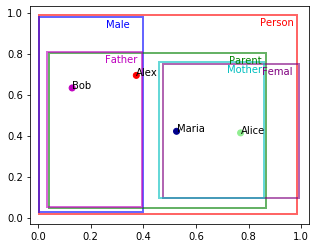

In [43]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

def plot_box(boxes, relation, scaling_emb, epoch, loss):
    clear_output(wait=True)
    plt.figure(figsize=(5,4))

#     plt.subplot(121)
    
    labels = ['Person','Male','Parent','Femal','Father','Mother']
    color = ['r','b','g','purple','m','c']
    
    # Plot individual embedding
    x = model.entity_embedding.cpu().detach().numpy()[:,0]
    y = model.entity_embedding.cpu().detach().numpy()[:,1]
    label = ['Alex','Bob','Alice','Maria']
    plt.scatter(x,y,c=['r','m','lightgreen','darkblue'])
    for i, txt in enumerate(label):
        plt.annotate(txt, (x[i], y[i]))

    # Plot concept embedding
    for i in range(boxes.min_embed.shape[0]-1):
        x1,x2,w,h = boxes.min_embed[i][0],boxes.min_embed[i][1],boxes.max_embed[i][0]-boxes.min_embed[i][0], boxes.max_embed[i][1]-boxes.min_embed[i][1]
        rect=mpatches.Rectangle((x1,x2),w,h, fill = False, color = color[i],linewidth = 2, alpha=0.6, facecolor=color[i])
        plt.gca().add_patch(rect)
        plt.text(x1+w-0.14,x2+h-0.05, labels[i], color = color[i])
        
    plt.xlim(-0.03,1.03)
    plt.ylim(-0.03,1.03)
    plt.savefig('toy_example.pdf', dpi=1200)
    plt.show()

plot_box(boxes, rel_emb, scaling_emb, epoch, loss.item())
